# Import necessary libraries

In [18]:
import torch
import os
import wget
import json
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetRegressor
from pathlib import Path
from scipy.special import inv_boxcox

np.random.seed(0)
sb.set() 
model = TabNetRegressor(device_name='cuda') 


## Load necessary models 

In [3]:
from joblib import load

# Load the linear regression models
linreg = load('./models/linreg/linreg.joblib')
linreg_withLog = load('./models/linreg/linreg_log.joblib')
linreg_withBoxCox = load('./models/linreg/linreg_boxcox.joblib')

# Load the xgboost models
xgbreg = xgb.XGBRegressor()  
xgbreg.load_model('./models/xgb/xgb_linreg.json')

xgbreg_withLog = xgb.XGBRegressor()
xgbreg_withLog.load_model('./models/xgb/xgb_linreg_log.json')

xgbreg_withBoxCox = xgb.XGBRegressor()
xgbreg_withBoxCox.load_model('./models/xgb/xgb_linreg_box.json')

# load the tabnet models
tabnetReg_log = TabNetRegressor()
tabnetReg_log.load_model('./models/tabnet/tabnet_log.zip')  

tabnetReg_box = TabNetRegressor()
tabnetReg_box.load_model('./models/tabnet/tabnet_boxcox.zip') 


## Load necessary data

In [10]:
csv_data = pd.read_csv('data/clean_data/final_data.csv')
final_data = csv_data[csv_data['Year'] >= 2000]

test_data = pd.read_csv('./data/test/test.csv')

with open('data/clean_data/encoding_mappings.json', 'r') as fp:
    encoding_mappings = json.load(fp)

with open('./data/clean_data/lamda.json', "r") as fp:
    lamda = json.load(fp)

lambda_boxcox = lamda[0]
lambda_boxcox_tabnet  = lamda[1]


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63401 entries, 0 to 63400
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   63401 non-null  int64  
 1   floor_area_sqm         63401 non-null  float64
 2   lease_commence_date    63401 non-null  int64  
 3   average_storey         63401 non-null  float64
 4   town                   63401 non-null  int64  
 5   flat_type              63401 non-null  int64  
 6   flat_model             63401 non-null  int64  
 7   resale_price_adjusted  63401 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 3.9 MB


In [13]:
def encode_new_input(new_input, encoding_mappings):
# If new_input is a dictionary, convert it to a DataFrame
    if isinstance(new_input, dict):
        new_input = pd.DataFrame([new_input])
    
    # If new_input is a list of dictionaries, convert it to a DataFrame
    elif isinstance(new_input, list):
        new_input = pd.DataFrame(new_input)

    # Ensure that new_input is a DataFrame at this point
    if not isinstance(new_input, pd.DataFrame):
        raise ValueError("new_input must be a pandas DataFrame, a dictionary, or a list of dictionaries.")    
    new_input_encoded = new_input.copy()
    for column, mapping in encoding_mappings.items():
        if column in new_input.columns:
            # Apply the mapping to the column
            new_input_encoded[column] = new_input[column].map(mapping)
            # Fill in NaN values if the category was not seen during training
            if new_input_encoded[column].isna().any():
                unknown_rank = np.median(list(mapping.values()))
                # Use direct assignment instead of inplace=True
                new_input_encoded[column] = new_input_encoded[column].fillna(unknown_rank)
    
    return new_input_encoded

In [14]:
features = ['Year','floor_area_sqm', 'lease_commence_date', 'average_storey','town', 'flat_type', 'flat_model']
target = 'resale_price_adjusted'

In [19]:
X_test = test_data[features]
y_test = test_data[target]

# Predicting the linear regression models 
y_pred_linReg           = linreg.predict(X_test)
y_pred_linReg_log       = np.exp(linreg_withLog.predict(X_test))
y_pred_linReg_boxcox    = inv_boxcox(linreg_withBoxCox.predict(X_test), lambda_boxcox)

# Predicting the xgboost models 
y_pred_xgb              = xgbreg.predict(X_test)
y_pred_xgb_log          = np.exp(xgbreg_withLog.predict(X_test))
y_pred_xgb_boxcox       = inv_boxcox(xgbreg_withBoxCox.predict(X_test), lambda_boxcox)

# Predicting the tabnet models 
y_pred_tabnet_log       = np.exp(tabnetReg_log.predict(X_test.values))
y_pred_tabnet_boxcox    = inv_boxcox(tabnetReg_box.predict(X_test.values), lambda_boxcox_tabnet)


In [24]:
from IPython.display import display
import math

metrics_df = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Linear Regression with Log Transformation',
        'Linear Regression with BoxCox Transformation',
        'XGBoost',
        'XGBoost with Log Transformation',
        'XGBoost with BoxCox Transformation',
        'Tabnet with Log Transformation',
        'Tabnet with BoxCox Transformation'
    ],
    'R^2': [
        r2_score(y_test, y_pred_linReg),
        r2_score(y_test, y_pred_linReg_log),
        r2_score(y_test, y_pred_linReg_boxcox),
        r2_score(y_test, y_pred_xgb),
        r2_score(y_test, y_pred_xgb_log),
        r2_score(y_test, y_pred_xgb_boxcox),
        r2_score(y_test, y_pred_tabnet_log),
        r2_score(y_test, y_pred_tabnet_boxcox)
    ],
    'RMSE': [
        math.sqrt(mean_squared_error(y_test, y_pred_linReg)),
        math.sqrt(mean_squared_error(y_test, y_pred_linReg_log)),
        math.sqrt(mean_squared_error(y_test, y_pred_linReg_boxcox)),
        math.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        math.sqrt(mean_squared_error(y_test, y_pred_xgb_log)),
        math.sqrt(mean_squared_error(y_test, y_pred_xgb_boxcox)),
        math.sqrt(mean_squared_error(y_test, y_pred_tabnet_log)),
        math.sqrt(mean_squared_error(y_test, y_pred_tabnet_boxcox))
    ]
})

# Format the DataFrame to have more readable numbers.
pd.options.display.float_format = '{:,.4f}'.format

# Display the DataFrame.
display(metrics_df)

,Model,R^2,RMSE
0,Linear Regression,0.7396,"84,847.1891"
1,Linear Regression with Log Transformation,0.7387,"84,997.9419"
2,Linear Regression with BoxCox Transformation,0.7464,"83,733.4723"
3,XGBoost,0.9668,"30,277.1146"
4,XGBoost with Log Transformation,0.9671,"30,151.8764"
5,XGBoost with BoxCox Transformation,0.9668,"30,290.0584"
6,Tabnet with Log Transformation,0.9112,"49,552.4320"
7,Tabnet with BoxCox Transformation,0.9530,"36,042.7405"


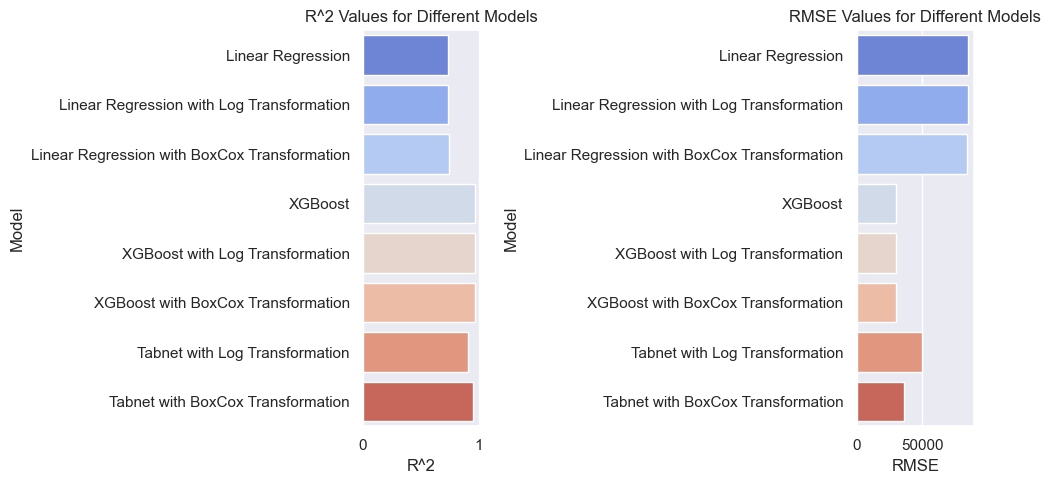

In [27]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

plt.figure(figsize=(10, 5))

# Create a bar plot for R^2 values
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sb.barplot(x='R^2', y='Model', data=metrics_df, palette='coolwarm')
plt.title('R^2 Values for Different Models')

# Create a bar plot for RMSE values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sb.barplot(x='RMSE', y='Model', data=metrics_df, palette='coolwarm')
plt.title('RMSE Values for Different Models')

# Display the plots
plt.tight_layout()
plt.show()

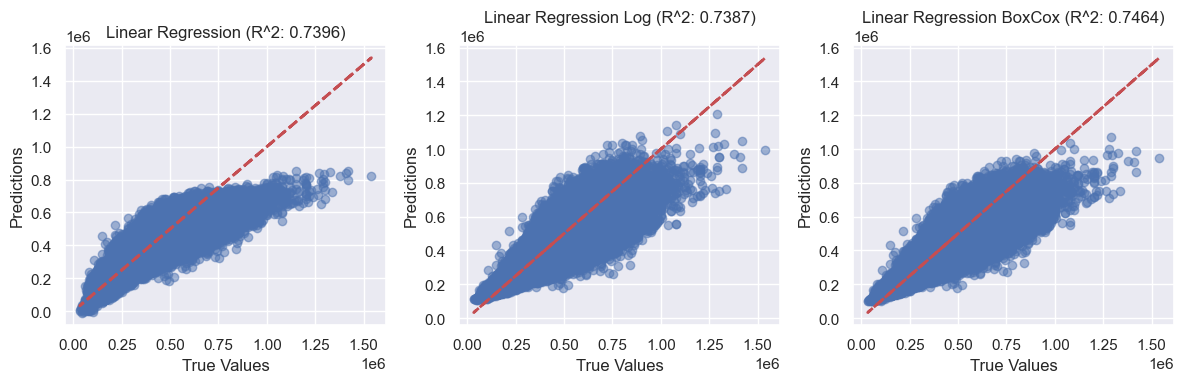

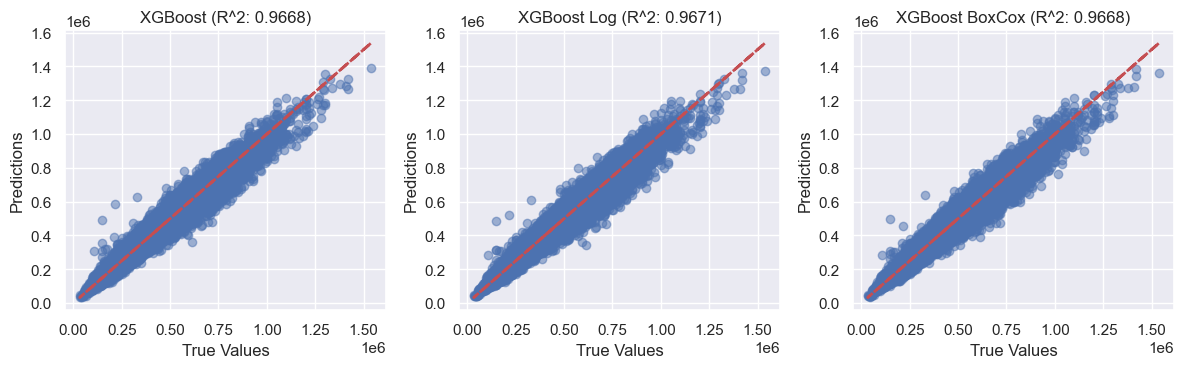

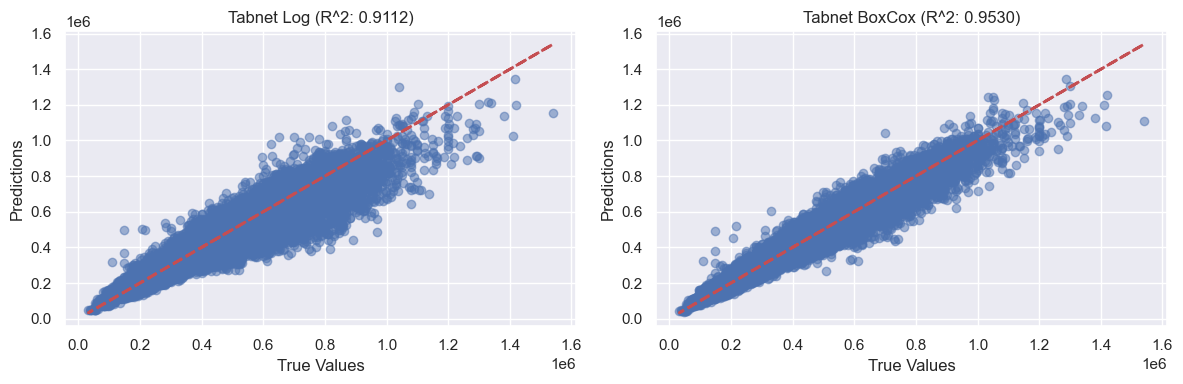

In [32]:
r2_values = metrics_df.set_index('Model')['R^2'].to_dict()

plt.figure(figsize=(12, 4))  

# Linear Regression Models
plt.subplot(1, 3, 1)  
plt.scatter(y_test, y_pred_linReg, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.title(f"Linear Regression (R^2: {r2_values['Linear Regression']:.4f})")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.subplot(1, 3, 2) 
plt.scatter(y_test, y_pred_linReg_log, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.title(f"Linear Regression Log (R^2: {r2_values['Linear Regression with Log Transformation']:.4f})")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.subplot(1, 3, 3) 
plt.scatter(y_test, y_pred_linReg_boxcox, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.title(f"Linear Regression BoxCox (R^2: {r2_values['Linear Regression with BoxCox Transformation']:.4f})")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.tight_layout()

# XGBoost Models
plt.figure(figsize=(12, 4))  

plt.subplot(1, 3, 1)  
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.title(f"XGBoost (R^2: {r2_values['XGBoost']:.4f})")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.subplot(1, 3, 2)  
plt.scatter(y_test, y_pred_xgb_log, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.title(f"XGBoost Log (R^2: {r2_values['XGBoost with Log Transformation']:.4f})")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.subplot(1, 3, 3)  
plt.scatter(y_test, y_pred_xgb_boxcox, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.title(f"XGBoost BoxCox (R^2: {r2_values['XGBoost with BoxCox Transformation']:.4f})")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.tight_layout()

# Tabnet Models
plt.figure(figsize=(12, 4)) 

plt.subplot(1, 2, 1) 
plt.scatter(y_test, y_pred_tabnet_log, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.title(f"Tabnet Log (R^2: {r2_values['Tabnet with Log Transformation']:.4f})")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.subplot(1, 2, 2)  
plt.scatter(y_test, y_pred_tabnet_boxcox, alpha=0.5)
plt.plot(y_test, y_test, 'r--', linewidth=2)
plt.title(f"Tabnet BoxCox (R^2: {r2_values['Tabnet with BoxCox Transformation']:.4f})")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.tight_layout()
plt.show()

In [34]:
for category, mappings in encoding_mappings.items():
    print(f"{category}:")
    for key, value in mappings.items():
        print(f"  {key}: {value}")
    print() 


town:
  GEYLANG: 0
  ANG MO KIO: 1
  YISHUN: 2
  BUKIT BATOK: 3
  BEDOK: 4
  CLEMENTI: 5
  WOODLANDS: 6
  JURONG EAST: 7
  TOA PAYOH: 8
  JURONG WEST: 9
  QUEENSTOWN: 10
  KALLANG/WHAMPOA: 11
  HOUGANG: 12
  BUKIT PANJANG: 13
  SERANGOON: 14
  CHOA CHU KANG: 15
  TAMPINES: 16
  SEMBAWANG: 17
  BUKIT MERAH: 18
  CENTRAL AREA: 19
  MARINE PARADE: 20
  PASIR RIS: 21
  BISHAN: 22
  SENGKANG: 23
  BUKIT TIMAH: 24
  PUNGGOL: 25

flat_type:
  1 ROOM: 0
  2 ROOM: 1
  3 ROOM: 2
  4 ROOM: 3
  5 ROOM: 4
  EXECUTIVE: 5
  MULTI-GENERATION: 6

flat_model:
  Simplified: 0
  New Generation: 1
  Standard: 2
  Model A2: 3
  2-room: 4
  Model A: 5
  Improved: 6
  Premium Apartment: 7
  Adjoined flat: 8
  Apartment: 9
  Improved-Maisonette: 10
  Model A-Maisonette: 11
  Maisonette: 12
  Multi Generation: 13
  Premium Maisonette: 14
  Terrace: 15
  3Gen: 16
  DBSS: 17
  Premium Apartment Loft: 18
  Type S1: 19
  Type S2: 20



In [39]:
new_sample = {
    'Year': 2024, 
    'floor_area_sqm': 100,
    'lease_commence_date': 2006,
    'average_storey': 10,
    'town': 'JURONG WEST',
    'flat_type': '5 ROOM',
    'flat_model': 'Premium Maisonette'
}

new_sample_df = pd.DataFrame([new_sample])

encoded_user_input = encode_new_input(new_sample_df, encoding_mappings)
encoded_user_input_array = encoded_user_input.to_numpy()

predicted_resale_price_linreg = linreg.predict(encoded_user_input)
predicted_resale_price_linreg_withLog = np.exp(linreg_withLog.predict(encoded_user_input))
predicted_resale_price_linreg_withBox = inv_boxcox(linreg_withBoxCox.predict(encoded_user_input), lambda_boxcox)

predicted_resale_price_xgb = xgbreg.predict(encoded_user_input)
predicted_resale_price_xgb_withLog = np.exp(xgbreg_withLog.predict(encoded_user_input))
predicted_resale_price_xgb_withBox = inv_boxcox(xgbreg_withBoxCox.predict(encoded_user_input), lambda_boxcox)

predicted_resale_price_tabnet_withLog = np.exp(tabnetReg_log.predict(encoded_user_input_array))
predicted_resale_price_tabnet_withBox = inv_boxcox(tabnetReg_box.predict(encoded_user_input_array), lambda_boxcox_tabnet)

print(f"Predicted Resale Value for Linear Regression:                               {predicted_resale_price_linreg[0]}")
print(f"Predicted Resale Value for Linear Regression with Log transformation:       {predicted_resale_price_linreg_withLog[0]}")
print(f"Predicted Resale Value for Linear Regression with BoxCox transformation:    {predicted_resale_price_linreg_withBox[0]}")
print()
print(f"Predicted Resale Value for XGBoost:                                         {predicted_resale_price_xgb[0]}")
print(f"Predicted Resale Value for XGBoost with Log transformation:                 {predicted_resale_price_xgb_withLog[0]}")
print(f"Predicted Resale Value for XGBoost with BoxCox transformation:              {predicted_resale_price_xgb_withBox[0]}")
print()
print(f"Predicted Resale Value for Tabnet with Log transformation:                  {predicted_resale_price_tabnet_withLog[0]}")
print(f"Predicted Resale Value for Tabnet with BoxCox transformation:               {predicted_resale_price_tabnet_withBox[0]}")


Predicted Resale Value for Linear Regression:                               649073.6095297933
Predicted Resale Value for Linear Regression with Log transformation:       657362.5052630707
Predicted Resale Value for Linear Regression with BoxCox transformation:    654613.8155545176

Predicted Resale Value for XGBoost:                                         760703.5
Predicted Resale Value for XGBoost with Log transformation:                 751227.4375
Predicted Resale Value for XGBoost with BoxCox transformation:              684534.875

Predicted Resale Value for Tabnet with Log transformation:                  [803868.4]
Predicted Resale Value for Tabnet with BoxCox transformation:               [692062.5]
